In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
import torch

from collections import defaultdict
import json
import numpy as np

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PestDetectDataset(torch.utils.data.Dataset):
    def __init__(self, root, set_type, transforms):
        self.root = root
        self.set_type = set_type
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        anns_file = os.path.join(self.root, self.set_type, "_annotations.coco.json")
        with open(anns_file, 'r') as f:
            self.anns = json.load(f)
        self.imgs = [image['file_name'] for image in self.anns["images"]]

    def __getitem__(self, idx):
        # load images and masks
        idx %= len(self.anns['annotations'])
        ann = self.anns['annotations'][idx]
        image_id = ann["image_id"]
        img_path = os.path.join(self.root, self.set_type, self.imgs[image_id])
        img = read_image(img_path)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        x1, y1, x2, y2 = ann["bbox"]
        if x1 == x2:
          x2 = x1+1
        if y1 == y2:
          y2 = y1+1
        bbox = [min(x1,x2), min(y1,y2), max(x1,x2), max(y1,y2)] #dirty data exist
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(bbox, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = torch.tensor([ann["category_id"]])
        target["image_id"] = image_id
        target["area"] = (target["boxes"][:, 3] - target["boxes"][:, 1]) * (target["boxes"][:, 2] - target["boxes"][:, 0])
        target["iscrowd"] = torch.zeros((1, ))

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 5  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [5]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
#backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    hidden_layer = 256

    return model

In [7]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

dataset_root = "/content/gdrive/My Drive/data/Pest Detection.v5i.coco"

# Since v0.15.0 torchvision provides `new Transforms API <https://pytorch.org/vision/stable/transforms.html>`_
# to easily write data augmentation pipelines for Object Detection and Segmentation tasks.
#
# Let’s write some helper functions for data augmentation /
# transformation:

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


# Testing ``forward()`` method (Optional)
# ---------------------------------------
#
# Before iterating over the dataset, it's good to see what the model
# expects during training and inference time on sample data.
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PestDetectDataset(dataset_root, 'train', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.0917, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0215, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.3702, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0382, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [8]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 5
# use our dataset and defined transformations
dataset = PestDetectDataset(dataset_root, 'train', get_transform(train=True))
dataset_test = PestDetectDataset(dataset_root, 'test', get_transform(train=False))

# split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [0]  [   0/1362]  eta: 1:09:12  lr: 0.000010  loss: 1.8911 (1.8911)  loss_classifier: 1.7677 (1.7677)  loss_box_reg: 0.0807 (0.0807)  loss_objectness: 0.0343 (0.0343)  loss_rpn_box_reg: 0.0084 (0.0084)  time: 3.0491  data: 0.4733  max mem: 1631
Epoch: [0]  [  10/1362]  eta: 0:14:08  lr: 0.000060  loss: 1.8911 (2.3859)  loss_classifier: 1.7677 (1.7207)  loss_box_reg: 0.0737 (0.0815)  loss_objectness: 0.0266 (0.4244)  loss_rpn_box_reg: 0.0084 (0.1593)  time: 0.6273  data: 0.0529  max mem: 1789
Epoch: [0]  [  20/1362]  eta: 0:11:24  lr: 0.000110  loss: 1.8730 (2.3749)  loss_classifier: 1.3358 (1.2969)  loss_box_reg: 0.0727 (0.0774)  loss_objectness: 0.0586 (0.7473)  loss_rpn_box_reg: 0.0100 (0.2532)  time: 0.3831  data: 0.0086  max mem: 1789
Epoch: [0]  [  30/1362]  eta: 0:10:25  lr: 0.000160  loss: 0.6674 (1.7805)  loss_classifier: 0.3532 (0.9443)  loss_box_reg: 0.0727 (0.0782)  loss_objectness: 0.1455 (0.5571)  loss_rpn_box_reg: 0.0281 (0.2010)  time: 0.3831  data: 0.0067  max me

tensor([  8,  12, 398, 389], device='cuda:0') 
 Fruit Moth: 0.311


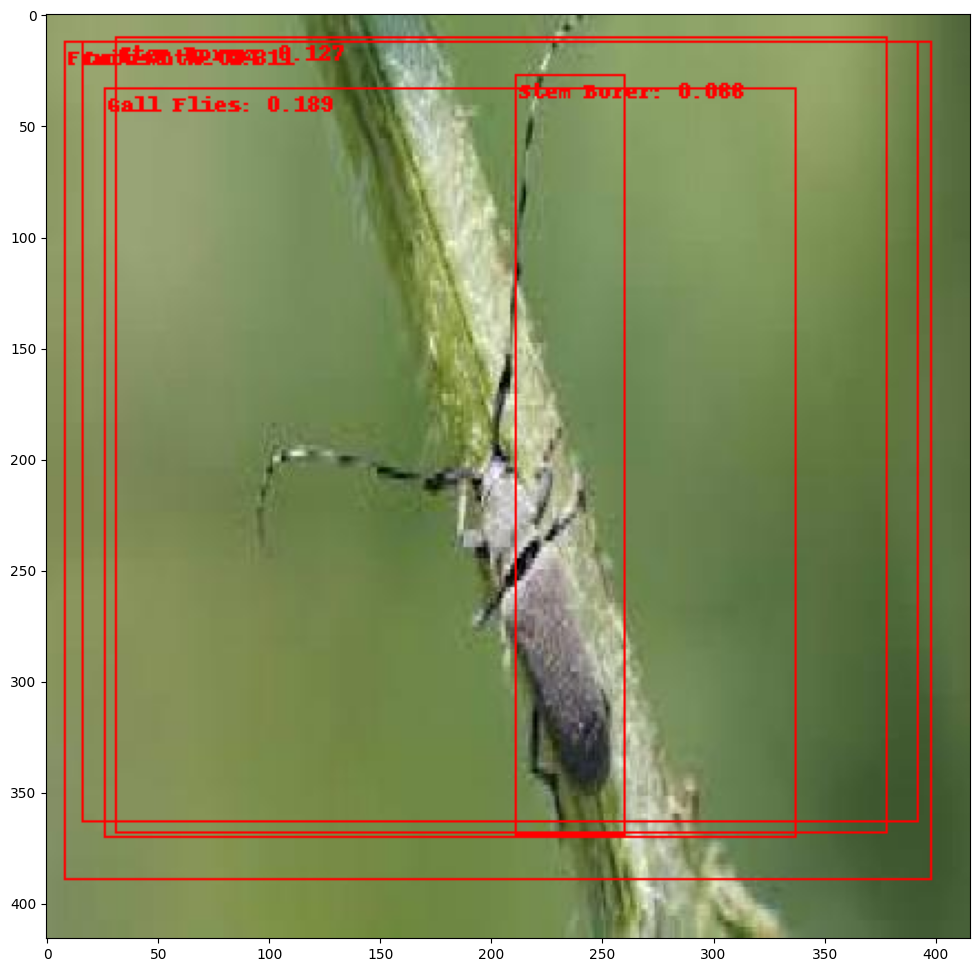

In [11]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image(dataset_root+"/valid/StemBorerImage82_jpg.rf.768eab6f74884efb0446b28e14de8caa.jpg")
eval_transform = get_transform(train=False)
cat = ["pest", "Fruit Moth", "Gall Flies", "Locust", "Stem Borer"]

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{cat[label]}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
print(pred_labels[0])
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))